In [1]:
import glob
import numpy as np
from astropy.io import fits
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# HDU_list = fits.open("spectra/spec-0387-51791-0005.fits")


all_flux = []
all_lambda = []
SN_array = np.array([])

# Kleinman DA Spectra
for filename in glob.glob("/Users/MichaelFoley/Documents/WDSpectralFitting/data/DA_high_SN_07544.fits"):
    data = fits.getdata(filename, 1)
    
    temp = fits.getdata(filename, 2)
    SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])
    
    all_flux.append(data['flux'])
    all_lambda.append(10 ** data['loglam'])
    print data, data['flux']
    plt.plot(data['lambda'],data['flux'])
    stop

# ELM Spectra
for filename in glob.glob("spectra_ELM/*.fits"):
    data = fits.getdata(filename, 1)
    
    temp = fits.getdata(filename, 2)
    SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])
    
    all_flux.append(data['flux'])
    all_lambda.append(10 ** data['loglam'])


    

#    break
    

[ ( 296.65496826,  3.55629992,  0.00750199, 16,        16,  1.29592097,   2.88346267,  266.51571655)
 ( 290.18994141,  3.55640006,  0.00790576, 16,        16,  1.29558694,   2.83890724,  264.43099976)
 ( 283.74575806,  3.55649996,  0.00811077, 16,        16,  1.2952565 ,   2.80171084,  263.38604736)
 ...,
 (  14.39799118,  4.01669979,  0.        ,  0, 201326592,  0.        ,   0.        ,   10.49100304)
 (  14.86894989,  4.01679993,  0.        ,  0,         0,  0.82527739,  57.35527802,   10.48850155)
 (  15.33992577,  4.01690006,  0.19961485,  0,         0,  0.8257826 ,  34.78066635,   10.48598003)] [ 296.65496826  290.18994141  283.74575806 ...,   14.39799118   14.86894989
   15.33992577]


KeyError: "Key 'lambda' does not exist."

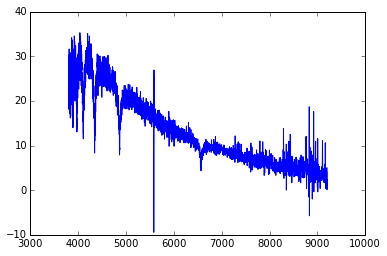

In [4]:
# Check a spectrum to make sure everything looks good
plt.plot(all_lambda[3],all_flux[3])
plt.show()

In [5]:
# First, find the highest S/N spectrum

index_best = np.argmax(SN_array)

print index_best

84


In [6]:
# Now, pad all spectra with zeros, so they span the wavelength range 3000-11000 Ang

temp_spec = np.arange(3000,11000,0.5)
new_flux = np.zeros([len(all_lambda),len(temp_spec)])

for index in range(len(all_lambda)):
    temp_grid = interp1d(all_lambda[index], all_flux[index],bounds_error = False, fill_value = 0.0)

    temp_flux = temp_grid(temp_spec)
    
    new_flux[index] = temp_flux
    


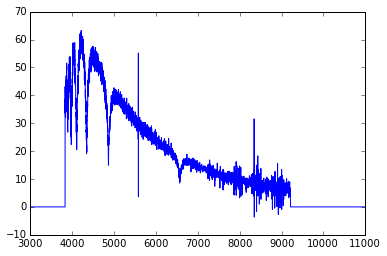

In [7]:
plt.plot(temp_spec,new_flux[9])
plt.show()

In [8]:
# Now, apply cross-correlation for each spectrum

shifts = np.array([])
for spec in new_flux:
    shifts = np.append(shifts, np.argmax(np.correlate(spec,all_flux[index_best])))

shifts = shifts.astype(int)
    

    
# Now, we shift the spectra by those values:
shifted_flux = np.zeros([len(new_flux),len(temp_spec)])
shifted_lambda = np.zeros([len(new_flux),len(temp_spec)])


for index in range(len(new_flux)):
    shifted_flux[index] = np.roll(new_flux[index],shifts[index])

    shifted_lambda[index] = temp_spec + shifts[index]/1000.0



16000


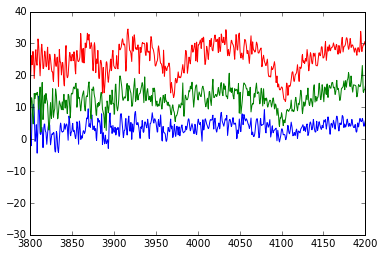

In [9]:
# And check a spectrum to see if it works

print len(new_flux[10])


plt.plot(temp_spec,new_flux[1])

plt.plot(temp_spec,new_flux[2])
plt.plot(temp_spec,new_flux[3])

# plt.plot(shifted_lambda[0],shifted_flux[0])
# plt.plot(shifted_lambda[3],shifted_flux[3])
# plt.plot(shifted_lambda[5],shifted_flux[5])

plt.xlim(3800,4200)

plt.show()


### Let's create our model

In [ ]:
# Our model has a temperature effect, then absorption features on top of the model


# Constants
h_planck = 4.136e-15
c_light = 2.998e10
k_boltz = 1.38e-16


# Balmer line features:
lambda_balmer = np.array([6563., 4861., 4341., 4102., 3970., 3889.])



# Calculate model spectrum
def model_flux(p, lamb):
    A_coeff, l_shift, T_eff, C_balmer = p
    
    flux = np.array([])
    
    lamb_p = lamb - l_shift
    flux = A_coeff * 2.0 * h_planck * c_light / (lamb_p*lamb_p*lamb_p) * 1.0 / (exp(h_planck * c_light / (k_boltz * Teff * lamb)) - 1.)
    for i in np.arange(6):
        flux = flux - C_balmer[i] * np.normal(lambda_balmer[i])

    return flux


# Likelihood function
def likelihood(flux, model_flux):
    
    # Need a S/N calculation in here
    diff = -(flux - model_flux)*(flux - model_flux)
    
    return np.sum(diff)

In [ ]:
# Model initial conditions

# initial T_eff = 10,000 K
Teff = 10000.0
# initial absorption coefficients 
C_balmer = np.ones(6)
# initial wavelength shift
l_shift = 0.0
# initial brightness coeff
A_coeff = 1.0



In [10]:
# Run PCA on spectra

n_components=4

#instantiate PCA class
pca = PCA(n_components=n_components)

# Fit spectra
pca.fit(new_flux)

# Get eigenvalues
eigs = pca.transform(new_flux)



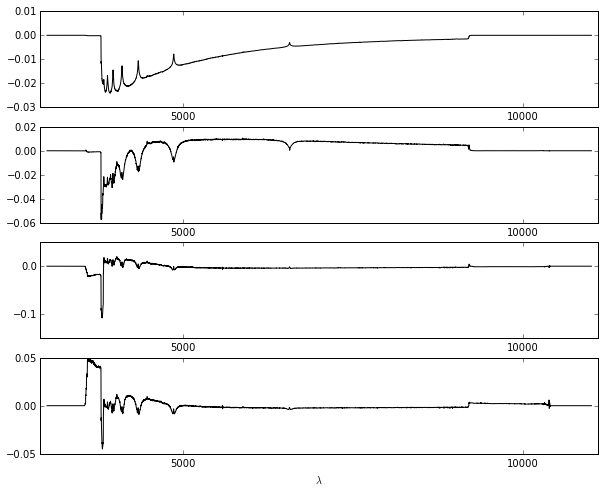

In [13]:


# plot eigenspectra
plt.figure(figsize=(10,10))
plt.subplot(n_components,1,1)



for i in np.arange(n_components):
	plt.subplot(n_components+1,1,i+2)
	plt.plot(temp_spec, pca.components_[i], color='k')
	plt.locator_params(nbins=4)
	plt.xlim([temp_spec[1]-100, temp_spec[-1]+100])
	plt.xlabel('$\lambda$')


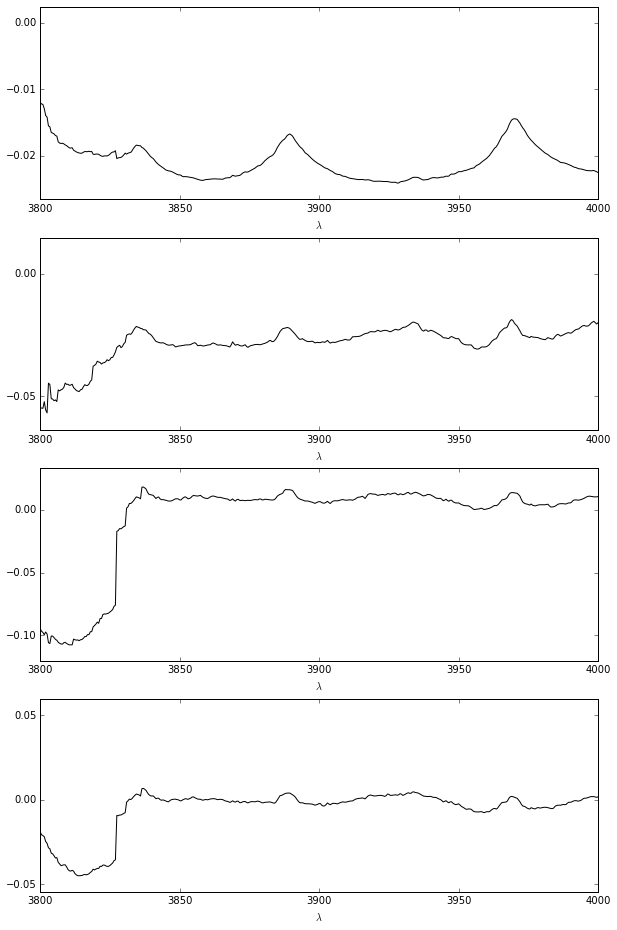

In [12]:


# plot eigenspectra
plt.figure(figsize=(10,20))
plt.subplot(n_components,1,1)

xmin = 3800
xmax = 4000
temp_array = np.array([])


for i in np.arange(n_components):
    plt.subplot(n_components+1,1,i+2)
    plt.plot(temp_spec, pca.components_[i], color='k')
    plt.locator_params(nbins=4)
    plt.xlim(xmin, xmax)
    
    temp_array = pca.components_[i][1000:4000]
    ymin = min(temp_array) - 0.1*(max(temp_array) - min(temp_array))
    ymax = max(temp_array) + 0.1*(max(temp_array) - min(temp_array))

    plt.ylim(ymin, ymax)
    plt.xlabel('$\lambda$')


In [ ]:
# 